In [1]:
from PIL import Image
import numpy as np
from skimage.measure import label, regionprops
import glob
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd

In [2]:
def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def calculate_dice_coefficient(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    dice = 2. * np.sum(intersection) / (np.sum(mask1) + np.sum(mask2))
    return dice

def calculate_pixel_accuracy(mask1, mask2):
    accuracy = np.sum(mask1 == mask2) / mask1.size
    return accuracy

def find_organoids(mask):
    labeled_mask = label(mask)
    props = regionprops(labeled_mask)
    return len(props)

def extract_time_from_filename(filenames):
    times = [filename.split('_')[-1].replace('h', '') for filename in filenames]
    times = [f"{int(time)}h" for time in times]
    return times

In [3]:
results = []
gt_mask_files = sorted(glob.glob('DataSetPreparation/Test_Set/GroundTruthMasks/*_mask.tif'))

for gt_mask_file in tqdm(gt_mask_files, desc = 'Analysing masks'):
    mask_id = os.path.basename(gt_mask_file).replace('_mask.tif', '')
    stardist_mask_file = f'DataSetPreparation/Test_Set/AlgorithmPredictions/{mask_id}_StarDistMask.tif'
    cellpose_mask_file = f'DataSetPreparation/Test_Set/AlgorithmPredictions/{mask_id}_CellposeMask.tif'

    gt_mask = np.array(Image.open(gt_mask_file)) > 0
    stardist_mask = np.array(Image.open(stardist_mask_file)) > 0
    cellpose_mask = np.array(Image.open(cellpose_mask_file)) > 0

    gt_count = find_organoids(gt_mask)
    stardist_count = find_organoids(stardist_mask)
    cellpose_count = find_organoids(cellpose_mask)

    result = {
        'Filename': mask_id,
        'GroundTruth': {'Organoid Count': gt_count},
        'StarDist': {'Organoid Count': stardist_count,
                     'IoU': calculate_iou(gt_mask, stardist_mask),
                     'Dice': calculate_dice_coefficient(gt_mask, stardist_mask),
                     'Pixel Accuracy': calculate_pixel_accuracy(gt_mask, stardist_mask)},
        'Cellpose': {'Organoid Count': cellpose_count,
                     'IoU': calculate_iou(gt_mask, cellpose_mask),
                     'Dice': calculate_dice_coefficient(gt_mask, cellpose_mask),
                     'Pixel Accuracy': calculate_pixel_accuracy(gt_mask, cellpose_mask)}
    }

    results.append(result)

Analysing masks:   0%|          | 0/20 [00:00<?, ?it/s]

In [4]:
# Create a list of dictionaries for each result in the desired format
formatted_results = []

for result in results:
    formatted_result = {
        'Image': result['Filename'] + '.tif',
        'StarDist IoU': round(result['StarDist']['IoU'], 3),
        'StarDist Dice Coefficient': round(result['StarDist']['Dice'], 3),
        'StarDist Pixel Accuracy': round(result['StarDist']['Pixel Accuracy'], 3),
        'Cellpose IoU': round(result['Cellpose']['IoU'], 3),
        'Cellpose Dice Coefficient': round(result['Cellpose']['Dice'], 3),
        'Cellpose Pixel Accuracy': round(result['Cellpose']['Pixel Accuracy'], 3)
    }
    formatted_results.append(formatted_result)

# Create a DataFrame from the formatted results
df = pd.DataFrame(formatted_results)

# Save the DataFrame as a CSV file
df.to_csv('image_metrics.csv', index=False)

df

,Image,StarDist IoU,StarDist Dice Coefficient,StarDist Pixel Accuracy,Cellpose IoU,Cellpose Dice Coefficient,Cellpose Pixel Accuracy
0,human_1_004h.tif,0.793,0.885,0.995,0.995,0.997,1.000
1,human_1_008h.tif,0.826,0.905,0.996,0.936,0.967,0.998
2,human_1_012h.tif,0.873,0.932,0.997,0.998,0.999,1.000
3,human_1_016h.tif,0.872,0.932,0.997,0.977,0.988,1.000
4,human_1_020h.tif,0.853,0.921,0.997,0.990,0.995,1.000
5,human_1_024h.tif,0.799,0.888,0.995,1.000,1.000,1.000
6,human_1_028h.tif,0.797,0.887,0.995,0.971,0.985,0.999
7,human_1_032h.tif,0.820,0.901,0.996,0.928,0.962,0.998
8,human_1_036h.tif,0.809,0.894,0.996,0.958,0.979,0.999
9,human_1_040h.tif,0.790,0.883,0.996,0.995,0.998,1.000


In [5]:
# df['Image'] = df['Image'].str.replace('_', r'\_')

# # Convert DataFrame to LaTeX table
# latex_table = df.to_latex(index=False, escape=False)

# # Print the LaTeX table
# print(latex_table)

In [6]:
stardist_organoid_counts = []
cellpose_organoid_counts = []
ground_truth_counts = []

filenames = []

for result in results:
    stardist_organoid_counts.append(result['StarDist']['Organoid Count'])
    cellpose_organoid_counts.append(result['Cellpose']['Organoid Count'])
    ground_truth_counts.append(result['GroundTruth']['Organoid Count'])
    filenames.append(f"{result['Filename']}")

In [7]:
# Segregate the data into human and mouse based on the filenames
human_stardist_counts = []
human_cellpose_counts = []
human_ground_truth_counts = []
human_filenames = []

mouse_stardist_counts = []
mouse_cellpose_counts = []
mouse_ground_truth_counts = []
mouse_filenames = []

for result in results:
    if 'human' in result['Filename']:
        human_stardist_counts.append(result['StarDist']['Organoid Count'])
        human_cellpose_counts.append(result['Cellpose']['Organoid Count'])
        human_ground_truth_counts.append(result['GroundTruth']['Organoid Count'])
        human_filenames.append(f"{result['Filename']}")
    elif 'mouse' in result['Filename']:
        mouse_stardist_counts.append(result['StarDist']['Organoid Count'])
        mouse_cellpose_counts.append(result['Cellpose']['Organoid Count'])
        mouse_ground_truth_counts.append(result['GroundTruth']['Organoid Count'])
        mouse_filenames.append(f"{result['Filename']}")

In [8]:
human_times = extract_time_from_filename(human_filenames)
mouse_times = extract_time_from_filename(mouse_filenames)

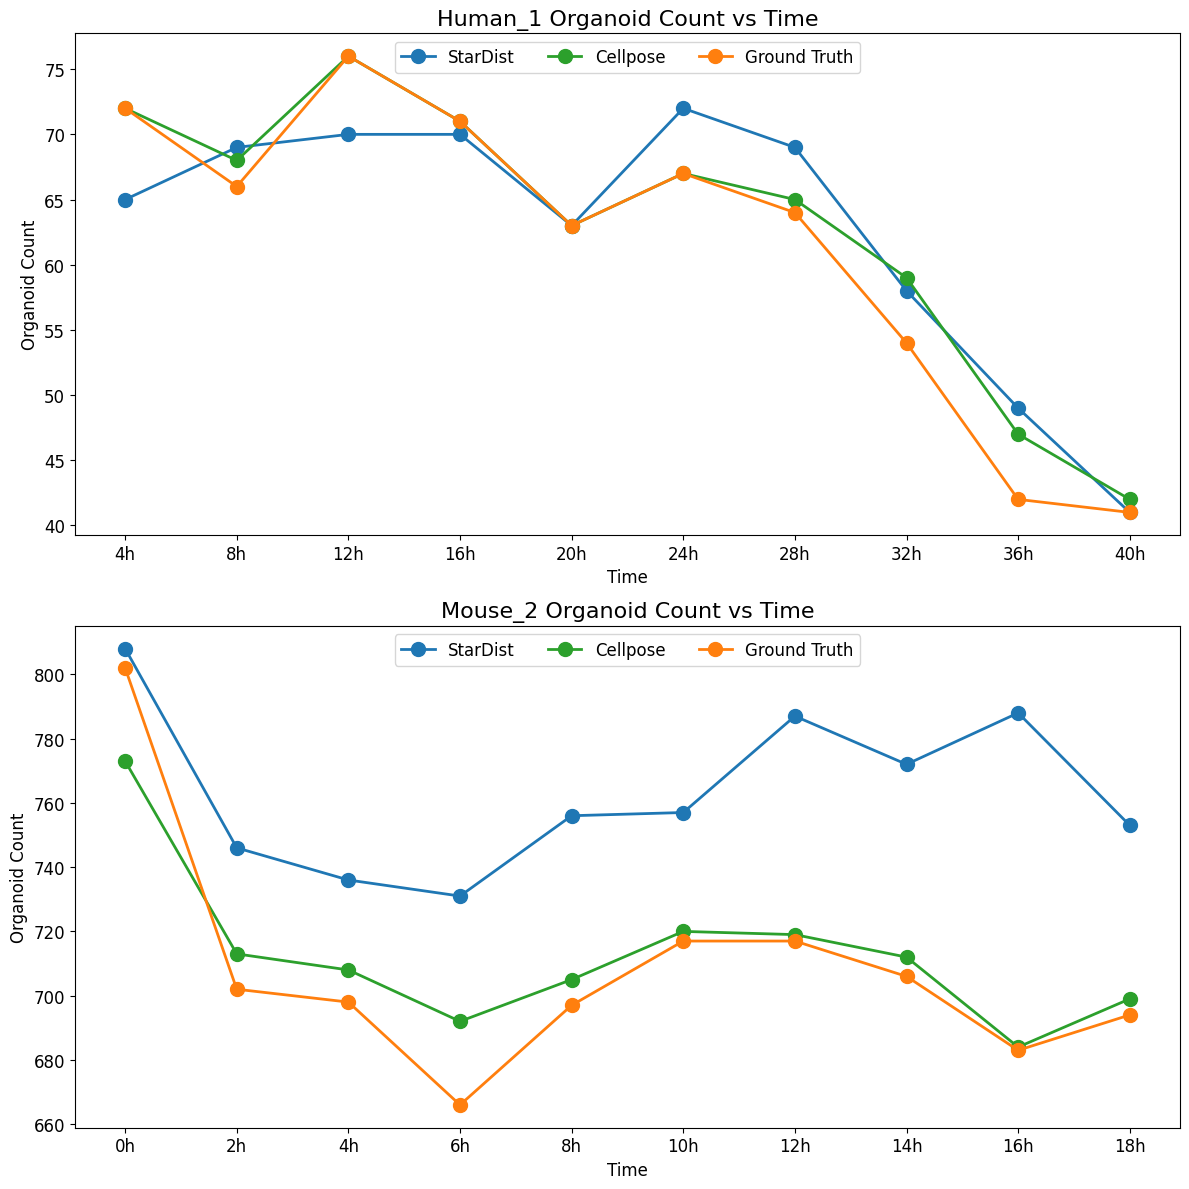

In [9]:
# Combined Line Plot for Human and Mouse Data
fig_combined = plt.figure(figsize=(12, 12))

# Human Data Line Plot
ax_human_combined = fig_combined.add_subplot(211) # Human plot
ax_human_combined.plot(human_times, human_stardist_counts, marker='o', linewidth=2, markersize=10,
                       color='tab:blue', label='StarDist')
ax_human_combined.plot(human_times, human_cellpose_counts, marker='o', linewidth=2, markersize=10,
                       color='tab:green', label='Cellpose')
ax_human_combined.plot(human_times, human_ground_truth_counts, marker='o', linewidth=2, markersize=10,
                       color='tab:orange', label='Ground Truth')
ax_human_combined.set_title('Human_1 Organoid Count vs Time', fontsize=16)
ax_human_combined.set_xlabel('Time', fontsize=12)
ax_human_combined.set_ylabel('Organoid Count', fontsize=12)
ax_human_combined.tick_params(axis='both', labelsize=12)
ax_human_combined.legend(ncol=3, loc='upper center', frameon=True, fontsize='large')

# Mouse Data Line Plot
ax_mouse_combined = fig_combined.add_subplot(212) # Mouse plot
ax_mouse_combined.plot(mouse_times, mouse_stardist_counts, marker='o', linewidth=2, markersize=10,
                       color='tab:blue', label='StarDist')
ax_mouse_combined.plot(mouse_times, mouse_cellpose_counts, marker='o', linewidth=2, markersize=10,
                       color='tab:green', label='Cellpose')
ax_mouse_combined.plot(mouse_times, mouse_ground_truth_counts, marker='o', linewidth=2, markersize=10,
                       color='tab:orange', label='Ground Truth')
ax_mouse_combined.set_title('Mouse_2 Organoid Count vs Time', fontsize=16)
ax_mouse_combined.set_xlabel('Time', fontsize=12)
ax_mouse_combined.set_ylabel('Organoid Count', fontsize=12)
ax_mouse_combined.tick_params(axis='both', labelsize=12)
ax_mouse_combined.legend(ncol=3, loc='upper center', frameon=True, fontsize='large')

plt.tight_layout()
plt.savefig('CombinedHumanMouseData.png', dpi=300, bbox_inches='tight')
plt.show()